In [23]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt


In [37]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")
n_biomarkers = 10

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg',
'R_inferiorparietal_thickavg',
'L_inferiortemporal_thickavg',
'R_inferiortemporal_thickavg',
'L_precuneus_thickavg',
'R_precuneus_thickavg',
'L_isthmuscingulate_thickavg',
'R_isthmuscingulate_thickavg',
'L_lateraloccipital_thickavg',
'R_lateraloccipital_thickavg']

small_region_set_resid = ['L_inferiorparietal_thickavg_resid',
'R_inferiorparietal_thickavg_resid',
'L_inferiortemporal_thickavg_resid',
'R_inferiortemporal_thickavg_resid',
'L_precuneus_thickavg_resid',
'R_precuneus_thickavg_resid',
'L_isthmuscingulate_thickavg_resid',
'R_isthmuscingulate_thickavg_resid',
'L_lateraloccipital_thickavg_resid',
'R_lateraloccipital_thickavg_resid']

#X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[small_region_set_resid]
X_resid = X_resid.to_numpy()
X_resid = np.max(X_resid, axis=0) - X_resid

X = df[small_region_set]
X = X.to_numpy()
X = np.max(X, axis=0) - X



print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

region_index = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]
K = np.take(np.take(K,region_index,axis=0), region_index, axis=1)

t_max = 30
step = 0.001


print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()
nhy = df["NHY"].to_numpy()
print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())


original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 10) X_resid.size:  (504, 10)
nans in cog: 0
infs in cog: 0


/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_years
No. Observations: 504     Method:             REML      
No. Groups:       146     Scale:              2.0152    
Min. group size:  2       Log-Likelihood:     -900.0355 
Max. group size:  4       Converged:          Yes       
Mean group size:  3.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.497    0.690  2.169 0.030  0.145  2.850
MCATOT        -0.002    0.024 -0.093 0.926 -0.050  0.046
PIGD_score     0.127    0.032  3.994 0.000  0.065  0.189
TD_score      -0.010    0.016 -0.607 0.544 -0.041  0.022
Group Var      0.000                                    



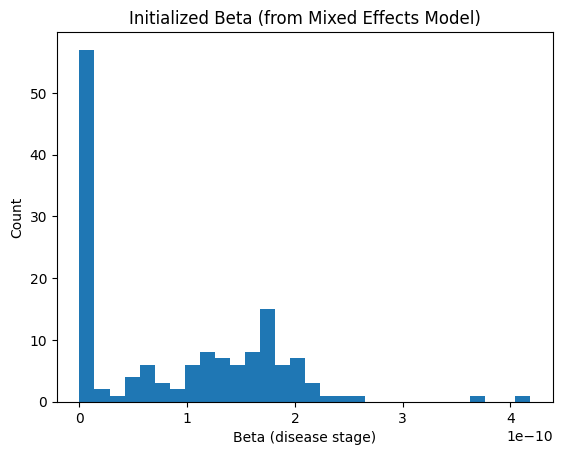

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import pandas as pd

# Select relevant columns
df_cog = df[["subj_id", "time", "MCATOT", "PIGD_score", "TD_score"]].copy()
df_cog["time_years"] = df_cog["time"] / 12
df_cog.dropna(subset=["time_years", "MCATOT", "PIGD_score", "TD_score"], inplace=True)
model = mixedlm("time_years ~ MCATOT + PIGD_score + TD_score", 
                data=df_cog, 
                groups=df_cog["subj_id"],
                re_formula="1")  # random intercept only

result = model.fit()
print(result.summary())

# Extract random intercepts as proxy for disease stage (lower intercept ~ earlier stage)
random_effects = result.random_effects
id_to_intercept = {pid: re["Group"] for pid, re in random_effects.items()}

# Map to beta_init for each subject
unique_ids = np.unique(df["subj_id"])
beta_init = np.array([id_to_intercept.get(pid, 0.0) for pid in unique_ids])

# Optionally rescale to [0, t_max] without normalization
beta_init = np.clip(beta_init, 0, t_max)

# Visualize
plt.hist(beta_init, bins=30)
plt.title("Initialized Beta (from Mixed Effects Model)")
plt.xlabel("Beta (disease stage)")
plt.ylabel("Count")
plt.show()


In [26]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk001_betaNN"
em_model_0 = EM(num_iterations=10, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.01, lambda_f=0.5, lambda_scalar=0.0)
# use_jacobian=True, lambda_cog=0.01, lambda_f=0.05, lambda_scalar=0.0)
em_model_0.fit(X=X_resid, dt=dt, ids=ids, cog=cog, K=K)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 1.0115468677064934
initial beta: (146,)
prepend complete


  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:07<00:16,  2.36s/it]

100%|██████████| 10/10 [09:25<00:00, 56.57s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.         0.00691709 0.0116996  0.00400974 0.00046145 0.00390684
 0.0384018  0.05887026 0.00650638 0.        ]


EM(lambda_cog=0.01, lambda_f=0.5, num_iterations=10,
   rng=Generator(PCG64) at 0x7F39C0797840, step=0.001, t_max=30)

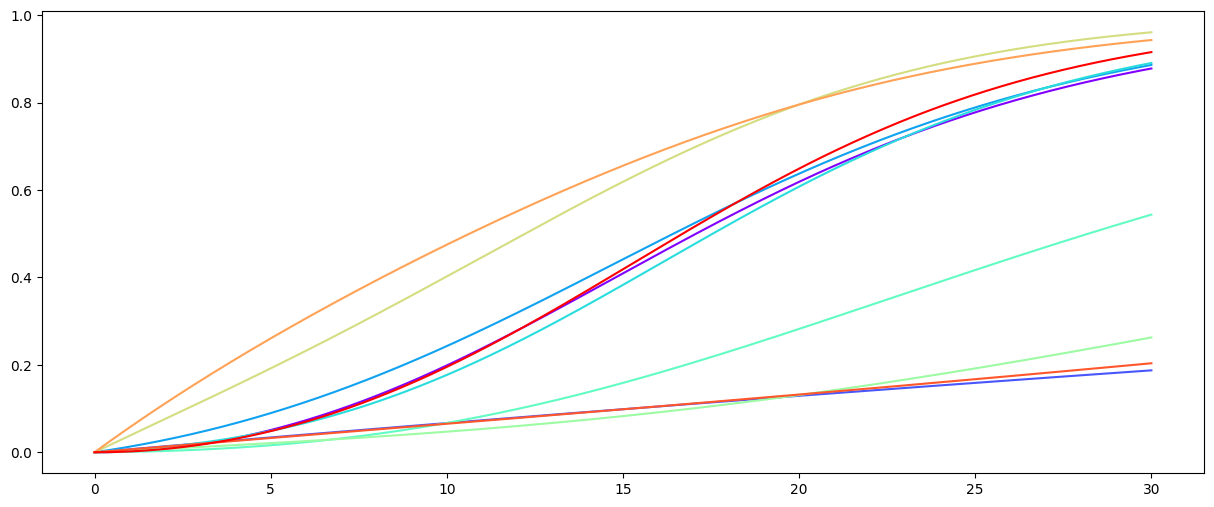

In [27]:
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

In [28]:
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s_k:  1.0115468677064934
final theta:
f:  [0.    0.007 0.012 0.004 0.    0.004 0.038 0.059 0.007 0.   ]
s:  [0.559 2.375 0.561 0.584 1.239 2.61  0.786 0.85  2.266 0.469]
s_k:  0.4106455288647754

BETA SUMMARY:
beta initial:  [25.12  29.519  6.072 10.503 12.852  5.351 29.883 27.227  7.544  2.734]
beta final:  [16.475 17.287 14.322 13.585 18.053 18.389 18.277 16.284 16.898 16.619]


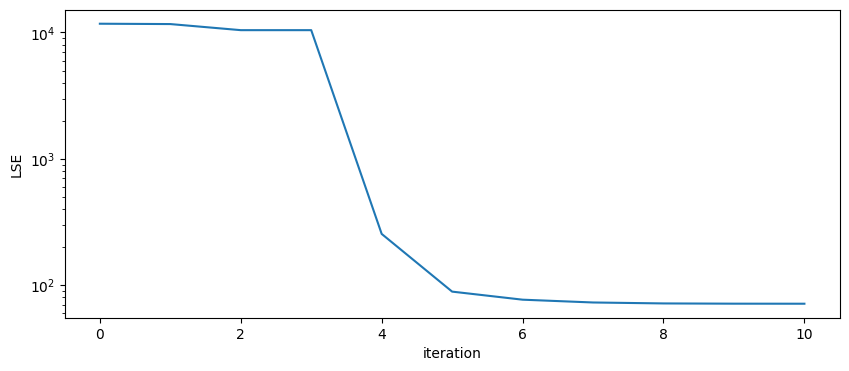

In [29]:
plot_lse(lse_history)

# plt.figure()
# plt.plot(lse_history[1:-1])
# plt.yscale('log')
# plt.show()

Unique PIDs: [3102 3105 3107 3108 3111 3113 3116 3118 3119 3120 3122 3123 3124 3125
 3126 3127 3128 3130 3131 3132 3134 3150 3154 3166 3173 3174 3175 3176
 3178 3179 3181 3182 3184 3185 3190 3305 3307 3308 3309 3314 3321 3323
 3325 3327 3328 3352 3354 3359 3360 3364 3365 3366 3367 3371 3372 3373
 3374 3375 3377 3378 3380 3383 3385 3386 3387 3392 3500 3552 3556 3557
 3558 3559 3564 3567 3574 3575 3577 3584 3585 3586 3587 3588 3591 3592
 3593 3752 3757 3758 3760 3762 3763 3770 3771 3775 3776 3777 3778 3780
 3781 3787 3789 3800 3802 3808 3814 3815 3818 3819 3822 3823 3824 3825
 3826 3828 3829 3830 3831 3832 3834 3835 3838 3863 3866 3868 3869 3870
 4001 4005 4011 4012 4013 4019 4020 4021 4022 4024 4025 4026 4027 4029
 4030 4034 4035 4037 4038 4136]
Counts: [2 4 4 4 2 3 3 4 2 4 2 3 4 4 3 2 3 3 3 4 3 3 4 3 3 4 4 2 4 4 3 3 3 3 4 2 4
 4 4 2 3 3 4 4 4 4 4 4 4 4 4 3 4 4 4 4 3 3 4 3 4 2 2 3 4 4 2 4 4 4 3 4 2 4
 3 4 3 2 4 4 3 4 3 3 4 3 4 3 4 3 4 3 2 4 4 4 4 4 3 3 4 4 4 4 4 4 3 4 4 4 4
 4 4 3 4 4 4

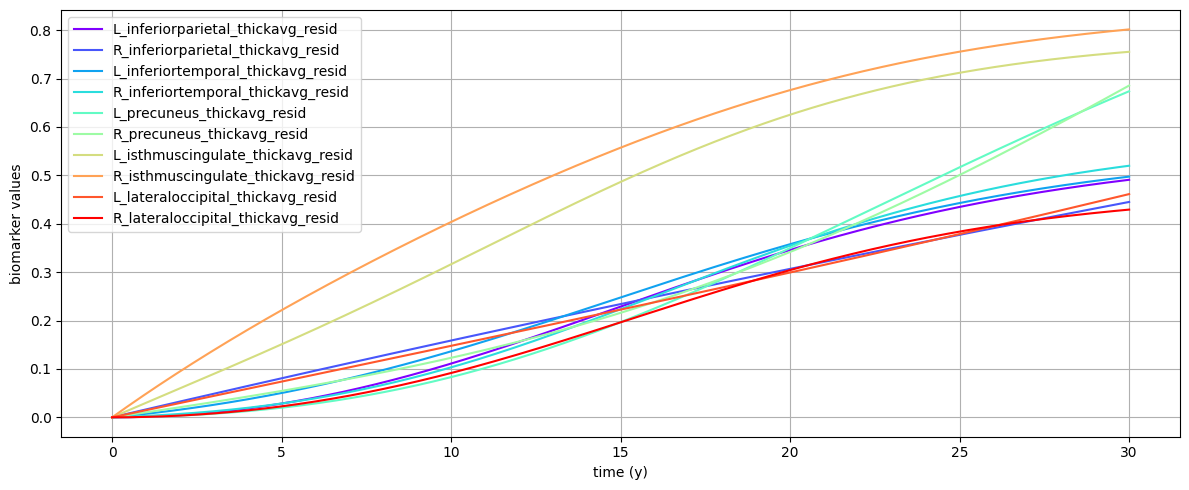

In [39]:
from sklearn.linear_model import LinearRegression

def plot_trajectories_with_patient_regression(X, dt, ids, beta, t_span, model, patient_id, biomarker_labels=None):

    n_biomarkers = model.shape[0]
    patient_mask = (ids == patient_id)
    
    X_i = X[patient_mask, :]
    print(X_i)
    dt_i = dt[patient_mask]
    beta_i = beta[np.unique(ids).tolist().index(patient_id)]
    t_ij = dt_i + beta_i 
    fig, ax = plt.subplots(figsize=(12, 5))
    
    
    for j in range(n_biomarkers):
        label = biomarker_labels[j]
        color = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))    

        ax.plot(t_span, model[j], label=label, color=color[j])        

    ax.set_xlabel("time (y)")
    ax.set_ylabel("biomarker values")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

unique_pids, counts = np.unique(ids, return_counts=True)
modal_pid = unique_pids[np.argmax(counts)]

print("Unique PIDs:", unique_pids)
print("Counts:", counts)
print("Modal PID:", modal_pid)

print(len(np.unique(ids)))
print(len(beta_history[:,-1]))
s = final_theta[n_biomarkers:2*n_biomarkers]

plot_trajectories_with_patient_regression(X_resid, dt, ids, beta_history[:,-1], t_span, final_model*s[:,None], ids[5], small_region_set_resid)

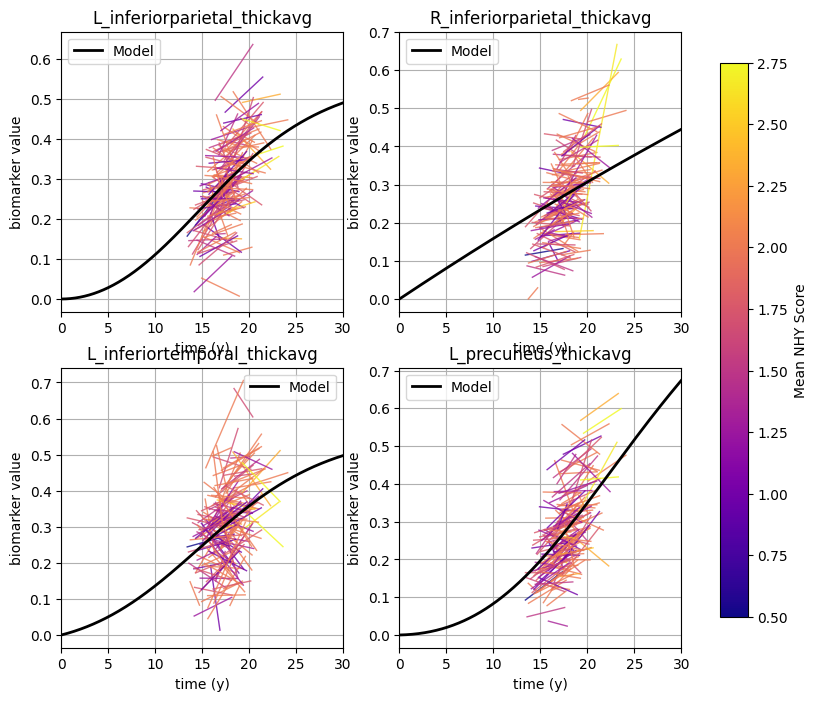

In [40]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_all_patient_regression_lines_grid_nhy(X, dt, ids, beta, t_span, nhy, model=None,
                                               biomarker_indices=None, biomarker_labels=None,
                                               max_lines=500, t_max=40):
    """
    Plot regression lines per patient for each selected biomarker on a grid of subplots.
    Each line is color-coded by the patient's mean NHY score.
    """
    if biomarker_indices is None:
        biomarker_indices = list(range(X.shape[1]))

    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}

    # Compute mean NHY score per patient
    mean_nhy = {}
    for pid in unique_ids:
        nhy_i = nhy[ids == pid]
        mean_nhy[pid] = np.mean(nhy_i) if len(nhy_i) > 0 else np.nan

    # Colormap setup
    cmap = cm.plasma  # or viridis, inferno, etc.
    nhy_vals = np.array(list(mean_nhy.values()))
    norm = colors.Normalize(vmin=np.nanmin(nhy_vals), vmax=np.nanmax(nhy_vals))

    n_plots = len(biomarker_indices)
    n_cols = math.ceil(np.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for plot_idx, j in enumerate(biomarker_indices):
        ax = axes[plot_idx]
        title = biomarker_labels[j] if biomarker_labels else f"biomarker {j}"
        ax.set_title(f"{title}")
        ax.set_xlabel("time (y)")
        ax.set_ylabel("biomarker value")

        line_count = 0
        for pid in unique_ids:
            if line_count >= max_lines:
                break
            mask = (ids == pid)
            if np.sum(mask) < 2:
                continue

            X_i = X[mask, j]
            dt_i = dt[mask]
            beta_i = beta[pid_to_index[pid]]
            t_ij = dt_i + beta_i

            nhy_mean = mean_nhy[pid]
            if np.isnan(nhy_mean):
                continue
            line_color = cmap(norm(nhy_mean))

            model_i = LinearRegression().fit(t_ij.reshape(-1, 1), X_i)
            t_fit = np.linspace(t_ij.min(), t_ij.max(), 20)
            x_fit = model_i.predict(t_fit.reshape(-1, 1))

            ax.plot(t_fit, x_fit, color=line_color, alpha=0.8, linewidth=1)
            line_count += 1

        # Plot model-predicted trajectory
        if model is not None:
            ax.plot(t_span, model[j], color='black', linewidth=2, label="Model")
            ax.legend()

        ax.grid(True)
        ax.set_xlim(0, t_max)

    # Remove unused axes
    for k in range(n_plots, len(axes)):
        fig.delaxes(axes[k])

    # Add colorbar for NHY scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='vertical', shrink=0.9)
    cbar.set_label("Mean NHY Score")

    plt.show()

plot_all_patient_regression_lines_grid_nhy(
    X=X_resid,
    dt=dt,
    ids=ids,
    beta=beta_history[:, -1],
    t_span=t_span,
    nhy=nhy,  # your NHY array
    model=final_model * s[:, None],
    biomarker_indices=[0, 1, 2, 4],
    biomarker_labels=small_region_set,
    max_lines=500,
    t_max=t_span[-1]
)


/tmp/ipykernel_8948/4096345311.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")


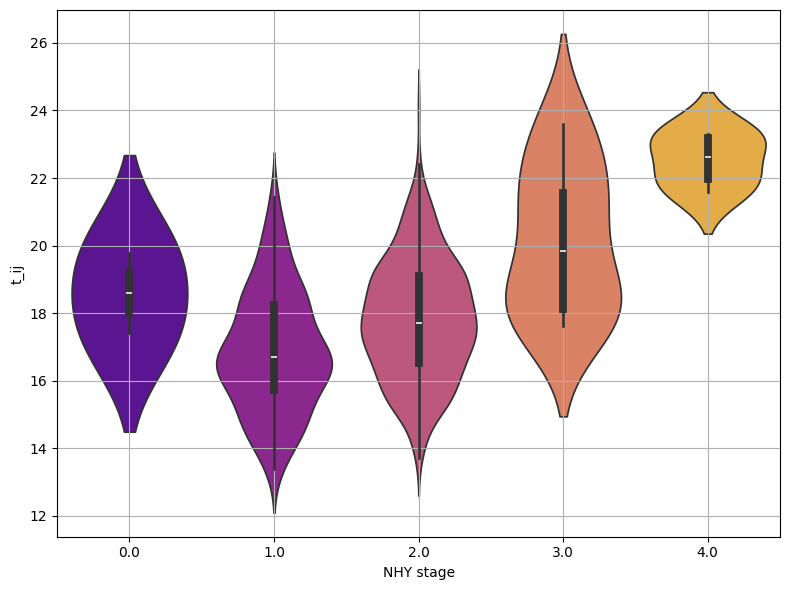

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_tij(dt, ids, beta, nhy):
    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}
    t_ij = np.array([dt_i + beta[pid_to_index[pid]] for dt_i, pid in zip(dt, ids)])

    df = pd.DataFrame({
        "t_ij": t_ij,
        "NHY": nhy
    })

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")
    plt.xlabel("NHY stage")
    plt.ylabel("t_ij")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_violin_nhy_vs_tij(dt=dt, ids=ids, beta=beta_history[:, -1], nhy=nhy)


2


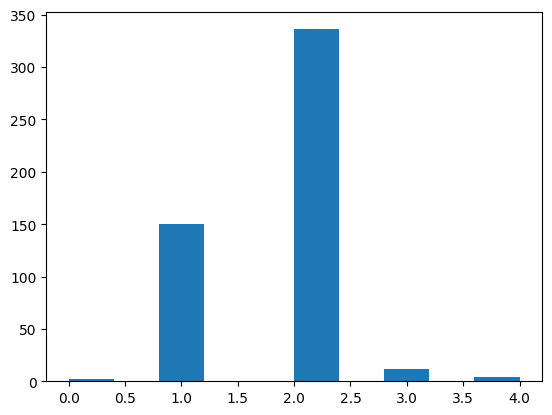

In [42]:
plt.hist(nhy)
print(sum(nhy==0))

/tmp/ipykernel_8948/1995190623.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="NHY", y="beta", palette="plasma", inner="box")


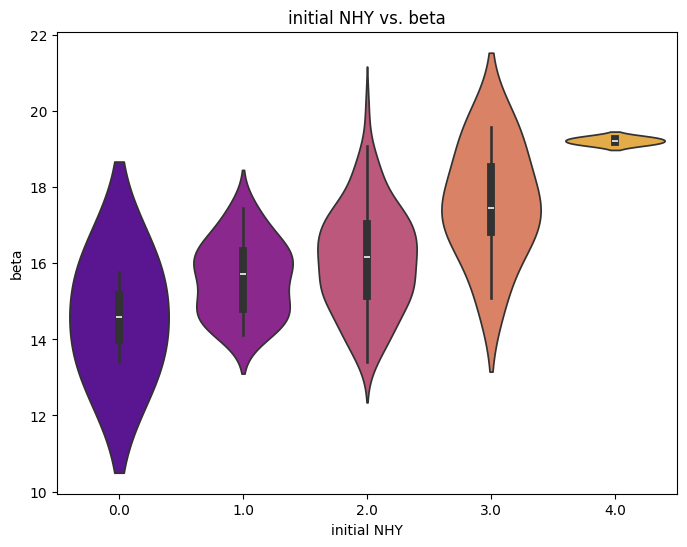

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_beta(ids, dt, nhy, beta):
    unique_ids = np.unique(ids)
    pair = []

    pid_to_beta = {pid: beta[i] for i, pid in enumerate(unique_ids)}

    for pid in unique_ids:
        mask = (ids == pid)
        dt_i = dt[mask]
        nhy_i = nhy[mask]
        idx_min_dt = np.argmax(dt_i)
        nhy_first = nhy_i[idx_min_dt]
        beta_i = pid_to_beta[pid]

        pair.append({"NHY": nhy_first, "beta": beta_i})

    df = pd.DataFrame(pair)

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x="NHY", y="beta", palette="plasma", inner="box")
    plt.title("initial NHY vs. beta")
    plt.xlabel("initial NHY")
    plt.ylabel("beta")
    plt.show()

plot_violin_nhy_vs_beta(ids=ids, dt=dt, nhy=nhy, beta=beta_history[:, -1])
